In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [3]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [4]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [5]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [6]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [7]:
num_sources = 15
spacing = 10 / resolution  

offsets = np.linspace(-width_sio2/2+spacing,
                       width_sio2/2-spacing,
                       num_sources)

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag]
    )
    for src in sources
]

     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.75,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.5,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.75,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
        

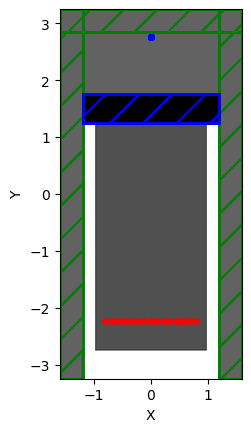

In [8]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(0, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

def J(fields):
    return npa.sum(npa.real(fields) ** 2)

opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=200,
    )
    for i in range(num_sources)
]

for i in range(num_sources):
    opt_list[i].plot2D(True)

In [18]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [19]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


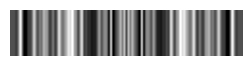


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


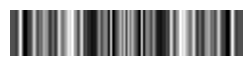


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


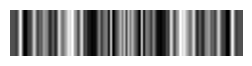


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


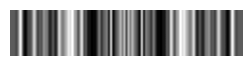


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


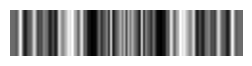


--- Iter 6 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


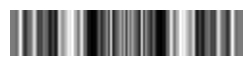


--- Iter 7 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


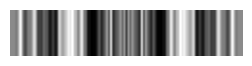


--- Iter 8 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


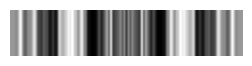


--- Iter 9 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...


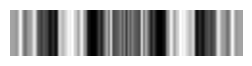


--- Iter 10 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

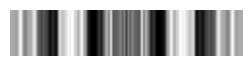


--- Iter 11 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

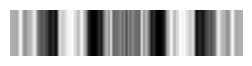


--- Iter 12 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

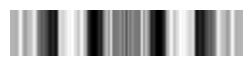


--- Iter 13 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

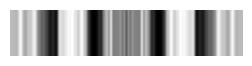


--- Iter 14 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

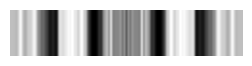


--- Iter 15 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

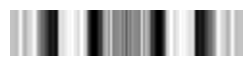


--- Iter 16 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

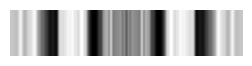


--- Iter 17 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

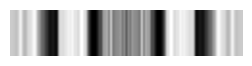


--- Iter 18 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

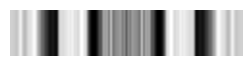


--- Iter 19 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

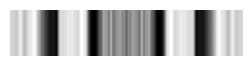


--- Iter 20 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

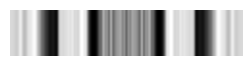


--- Iter 21 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

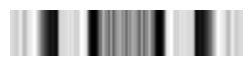


--- Iter 22 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

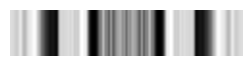


--- Iter 23 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

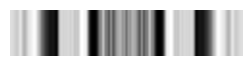


--- Iter 24 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

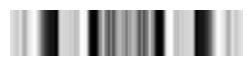


--- Iter 25 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

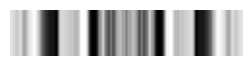


--- Iter 26 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

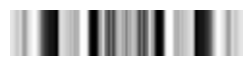


--- Iter 27 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

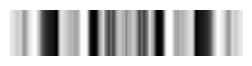


--- Iter 28 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

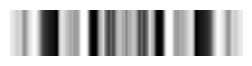


--- Iter 29 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

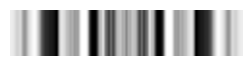


--- Iter 30 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

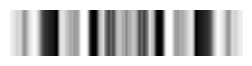


--- Iter 31 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

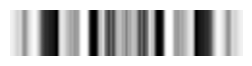


--- Iter 32 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

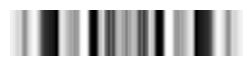


--- Iter 33 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

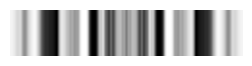


--- Iter 34 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

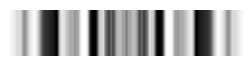


--- Iter 35 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

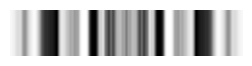


--- Iter 36 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

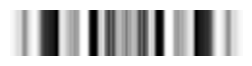


--- Iter 37 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

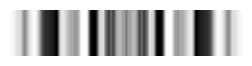


--- Iter 38 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

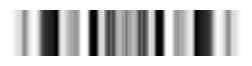


--- Iter 39 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

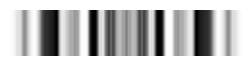


--- Iter 40 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

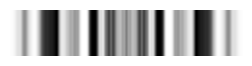


--- Iter 41 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

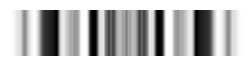


--- Iter 42 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

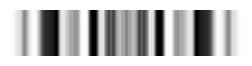


--- Iter 43 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

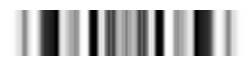


--- Iter 44 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

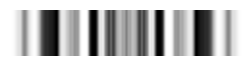


--- Iter 45 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

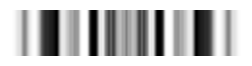


--- Iter 46 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

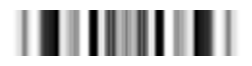


--- Iter 47 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

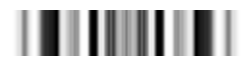


--- Iter 48 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

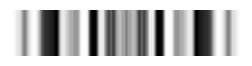


--- Iter 49 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

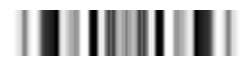


--- Iter 50 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

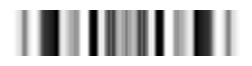


--- Iter 51 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

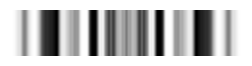


--- Iter 52 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

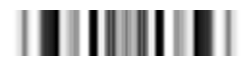


--- Iter 53 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

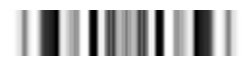


--- Iter 54 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

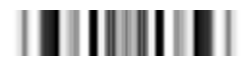


--- Iter 55 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

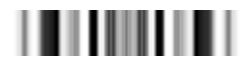


--- Iter 56 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

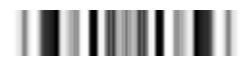


--- Iter 57 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

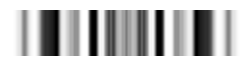


--- Iter 58 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

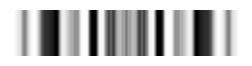


--- Iter 59 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

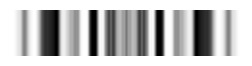


--- Iter 60 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

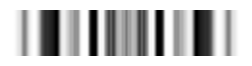


--- Iter 61 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

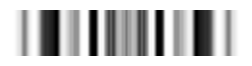


--- Iter 62 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

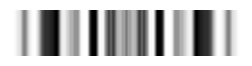


--- Iter 63 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

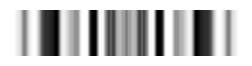


--- Iter 64 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

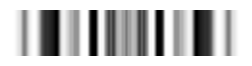


--- Iter 65 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

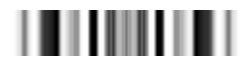


--- Iter 66 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

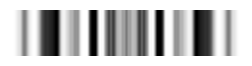


--- Iter 67 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

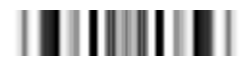


--- Iter 68 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

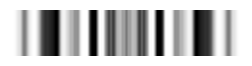


--- Iter 69 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

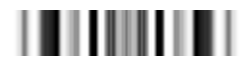


--- Iter 70 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

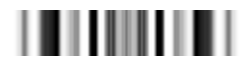


--- Iter 71 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

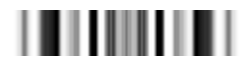


--- Iter 72 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

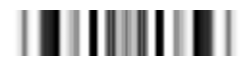


--- Iter 73 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

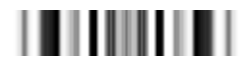


--- Iter 74 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

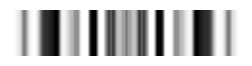


--- Iter 75 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

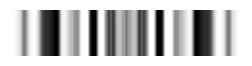


--- Iter 76 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

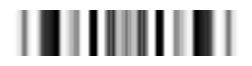


--- Iter 77 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

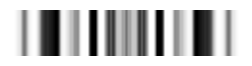


--- Iter 78 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

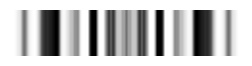


--- Iter 79 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

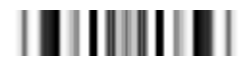


--- Iter 80 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

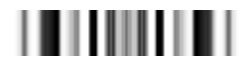


--- Iter 81 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

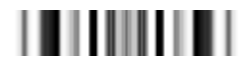


--- Iter 82 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

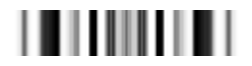


--- Iter 83 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

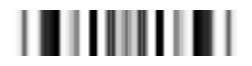


--- Iter 84 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

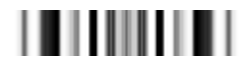


--- Iter 85 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

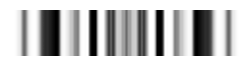


--- Iter 86 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

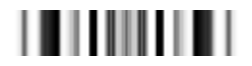


--- Iter 87 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

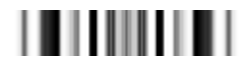


--- Iter 88 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

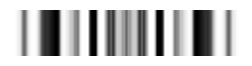


--- Iter 89 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

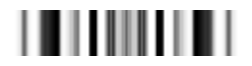


--- Iter 90 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

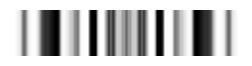


--- Iter 91 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

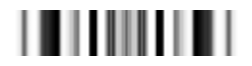


--- Iter 92 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

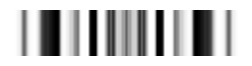


--- Iter 93 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

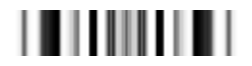


--- Iter 94 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

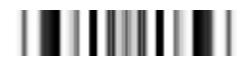


--- Iter 95 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

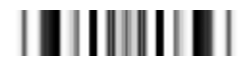


--- Iter 96 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

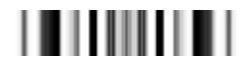


--- Iter 97 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

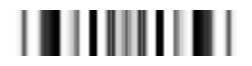


--- Iter 98 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

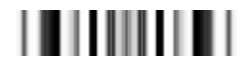


--- Iter 99 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...

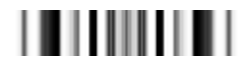


--- Iter 100 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

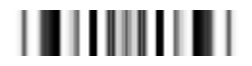


--- Iter 101 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

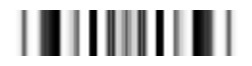


--- Iter 102 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

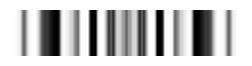


--- Iter 103 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

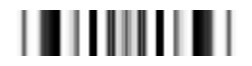


--- Iter 104 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

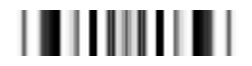


--- Iter 105 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

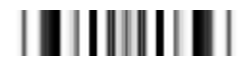


--- Iter 106 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

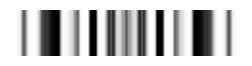


--- Iter 107 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

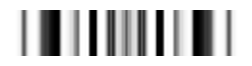


--- Iter 108 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

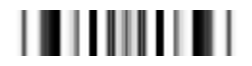


--- Iter 109 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

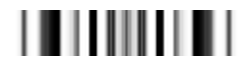


--- Iter 110 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

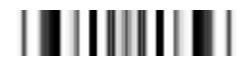


--- Iter 111 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

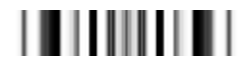


--- Iter 112 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

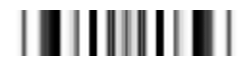


--- Iter 113 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

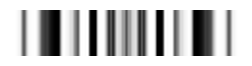


--- Iter 114 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

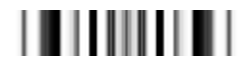


--- Iter 115 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

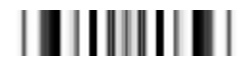


--- Iter 116 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

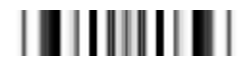


--- Iter 117 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

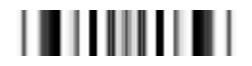


--- Iter 118 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

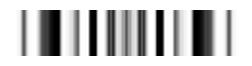


--- Iter 119 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

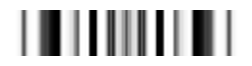


--- Iter 120 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

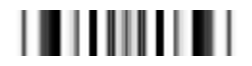


--- Iter 121 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

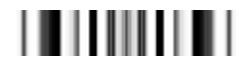


--- Iter 122 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

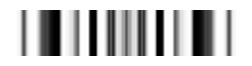


--- Iter 123 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

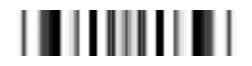


--- Iter 124 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

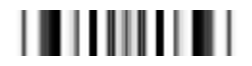


--- Iter 125 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

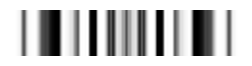


--- Iter 126 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

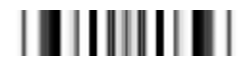


--- Iter 127 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

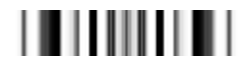


--- Iter 128 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

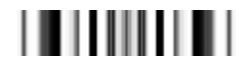


--- Iter 129 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

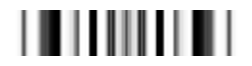


--- Iter 130 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

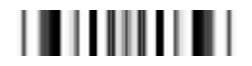


--- Iter 131 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

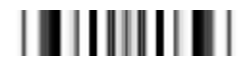


--- Iter 132 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

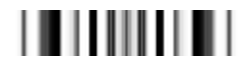


--- Iter 133 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

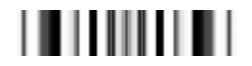


--- Iter 134 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

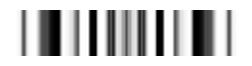


--- Iter 135 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

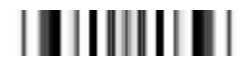


--- Iter 136 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

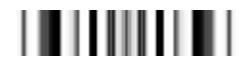


--- Iter 137 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

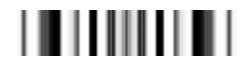


--- Iter 138 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

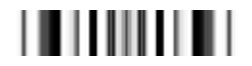


--- Iter 139 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

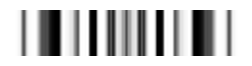


--- Iter 140 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

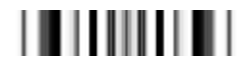


--- Iter 141 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

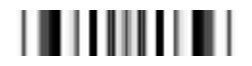


--- Iter 142 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

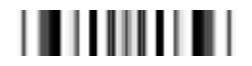


--- Iter 143 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

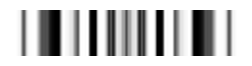


--- Iter 144 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

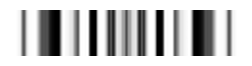


--- Iter 145 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

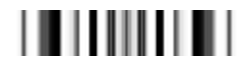


--- Iter 146 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

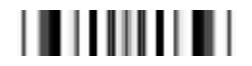


--- Iter 147 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

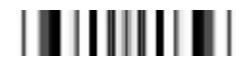


--- Iter 148 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

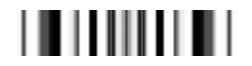


--- Iter 149 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

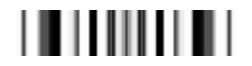


--- Iter 150 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run..

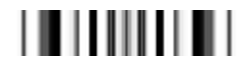

In [20]:
n = Nx * layer_num
np.random.seed(3)           
x = 0.4 + 0.2 * np.random.rand(n)  

cur_beta = 2

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.real(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # 평균 FoM 기준 변화율 계산 (💡 여기 수정!)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.002 and bin_change2 < 0.002):
            beta = beta + 12*np.tanh((beta - 0.5)*0.01)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")

    plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 150

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

최대 FoM = 0.531075 는 iteration 2123 에서 나왔습니다.


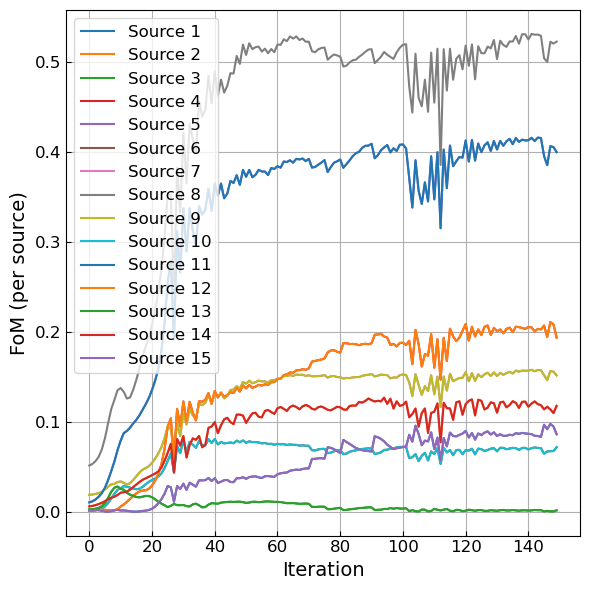

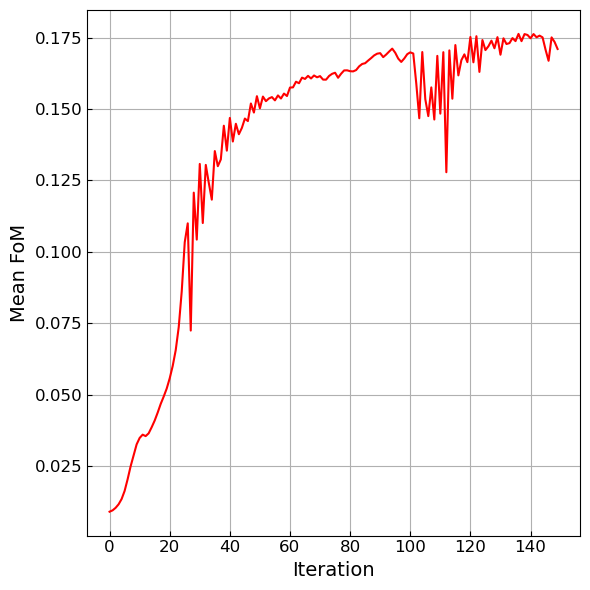

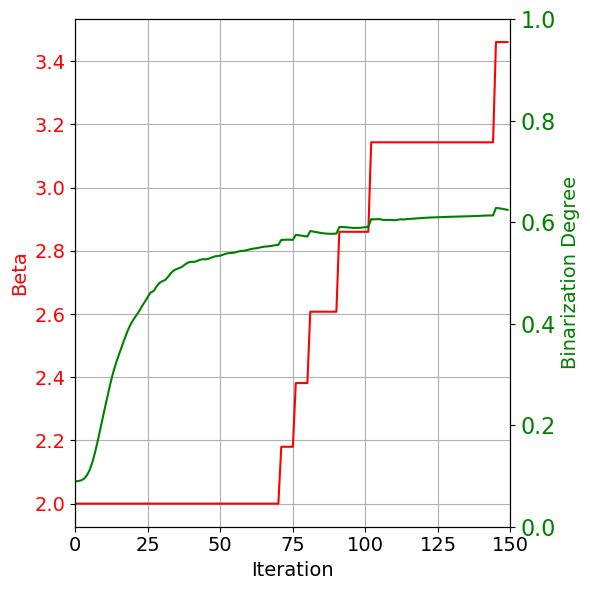

In [22]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom, 'r-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

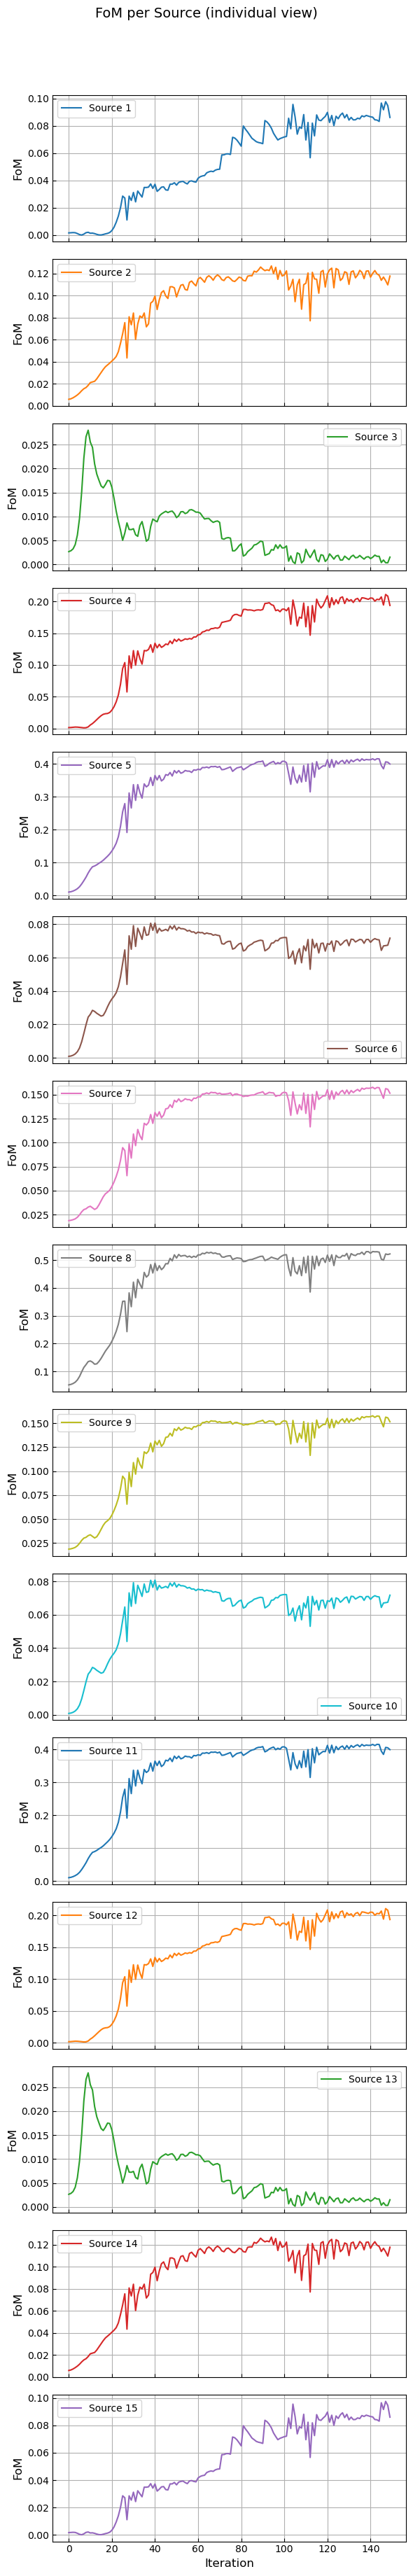

In [23]:
###################### [1-2] 각 소스별 FoM 개별 subplot ######################
num_sources = evaluation_array.shape[1]

fig, axs = plt.subplots(num_sources, 1, figsize=(6, 2.5*num_sources), sharex=True)

for i in range(num_sources):
    axs[i].plot(iterations, evaluation_array[:, i], label=f"Source {i+1}", color=f"C{i}")
    axs[i].set_ylabel("FoM", fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)
    axs[i].tick_params(labelsize=10, direction='in')

axs[-1].set_xlabel("Iteration", fontsize=12)
fig.suptitle("FoM per Source (individual view)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [9]:
# k = design_variables.weights
# np.savetxt("Dipole15_sum.txt", k)
design_load = np.loadtxt("Dipole15_sum.txt")
for i in range(len(sources)):
    opt_list[i].update_design([design_load])

Plotting geometry for Source 1


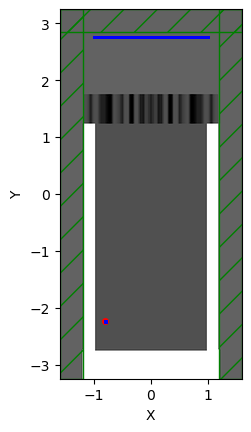

Plotting geometry for Source 2


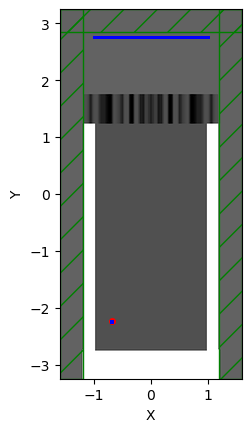

Plotting geometry for Source 3


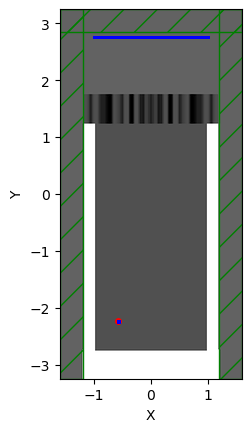

Plotting geometry for Source 4


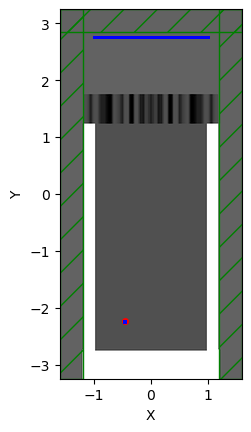

Plotting geometry for Source 5


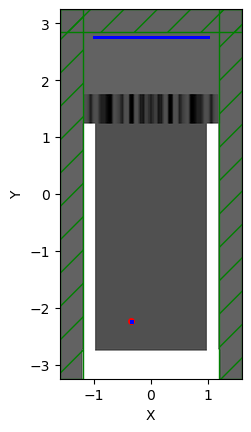

Plotting geometry for Source 6


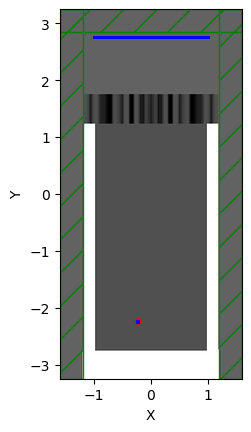

Plotting geometry for Source 7


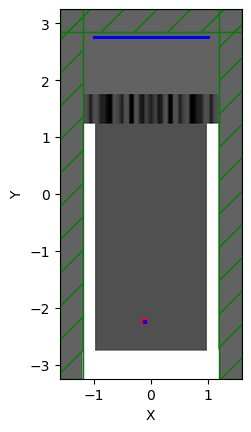

Plotting geometry for Source 8


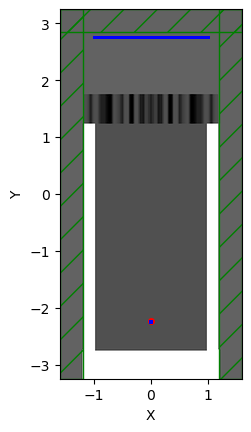

Plotting geometry for Source 9


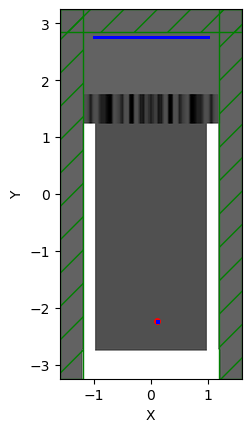

Plotting geometry for Source 10


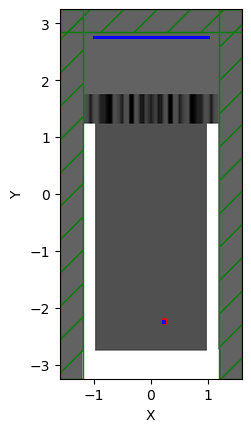

Plotting geometry for Source 11


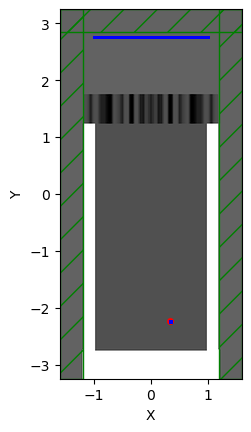

Plotting geometry for Source 12


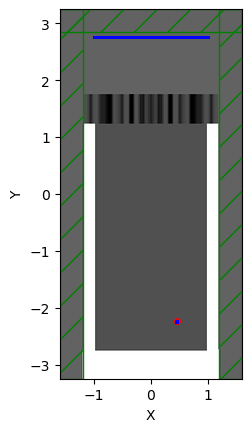

Plotting geometry for Source 13


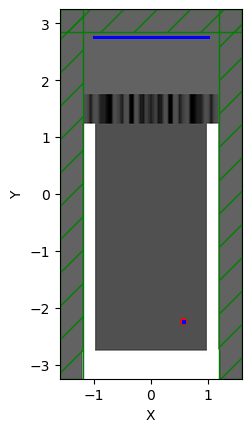

Plotting geometry for Source 14


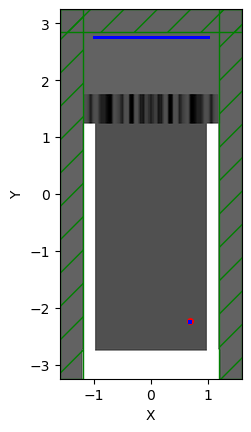

Plotting geometry for Source 15


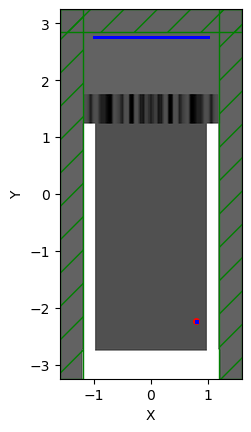

In [22]:
mp.verbosity(0)
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(mn_size, 0)

input_flux_list = []
output_flux_list = []
dft_fields_list = []

for i in range(len(sources)):
    sim_i = opt_list[i].sim
    source_i = sources[i]

    input_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=source_i.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=source_i.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    output_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    dft_fields = sim_i.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    print(f"Plotting geometry for Source {i+1}")
    opt_list[i].plot2D()
    plt.show()

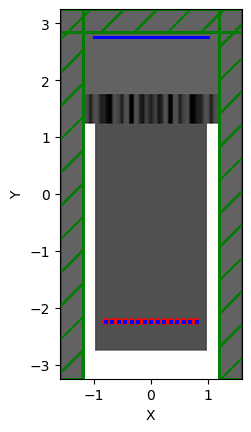

In [76]:
for i in range(num_sources):
    opt_list[i].plot2D()


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1
📊 Plotting 2D Ez for Source 1


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


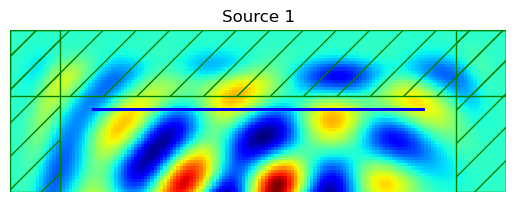

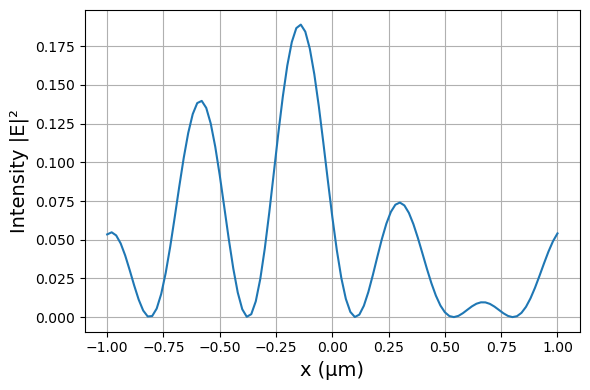


🔍 Source 1
  Input  flux : 0.173654
  Output flux : 0.136235
  EQE (%)     : 78.45 %

🔄 Iteration 시작 전 초기화: Source 2
▶️ Running Simulation for Source 2
📊 Plotting 2D Ez for Source 2


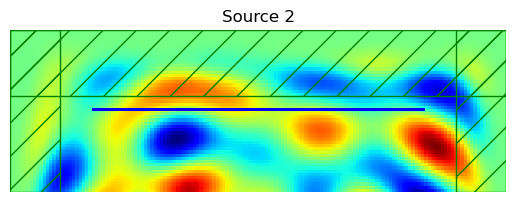

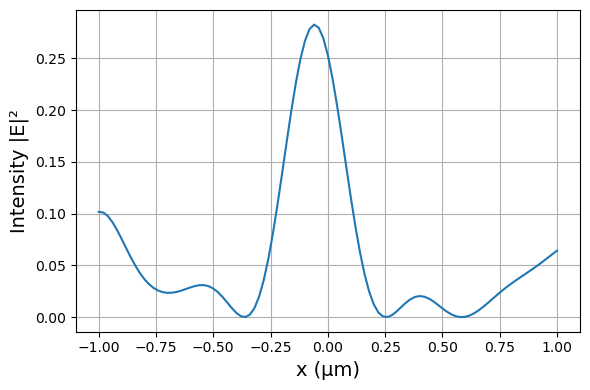


🔍 Source 2
  Input  flux : 0.146256
  Output flux : 0.129231
  EQE (%)     : 88.36 %

🔄 Iteration 시작 전 초기화: Source 3
▶️ Running Simulation for Source 3
📊 Plotting 2D Ez for Source 3


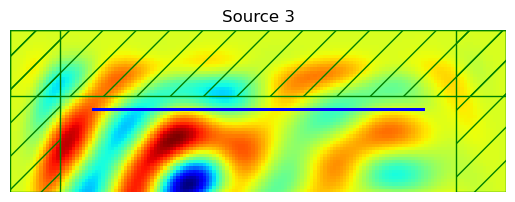

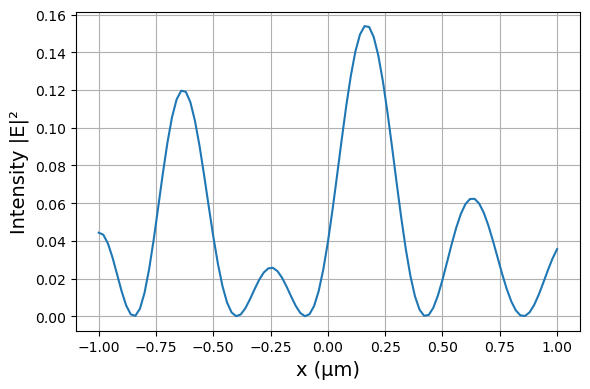


🔍 Source 3
  Input  flux : 0.132794
  Output flux : 0.125455
  EQE (%)     : 94.47 %

🔄 Iteration 시작 전 초기화: Source 4
▶️ Running Simulation for Source 4
📊 Plotting 2D Ez for Source 4


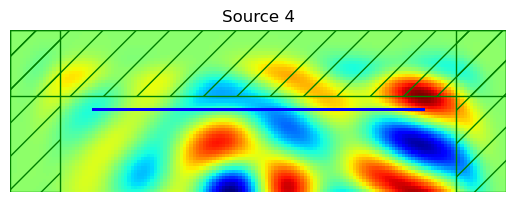

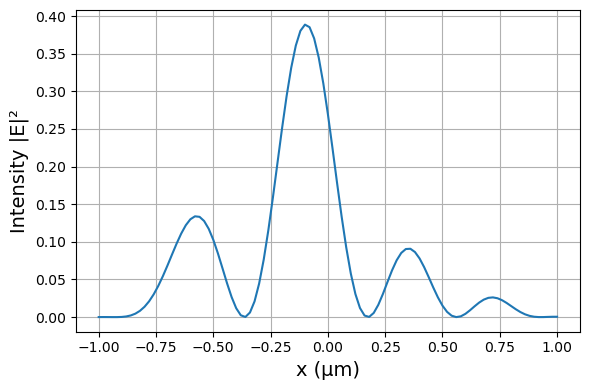


🔍 Source 4
  Input  flux : 0.198961
  Output flux : 0.168337
  EQE (%)     : 84.61 %

🔄 Iteration 시작 전 초기화: Source 5
▶️ Running Simulation for Source 5
📊 Plotting 2D Ez for Source 5


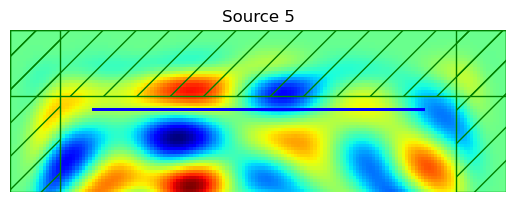

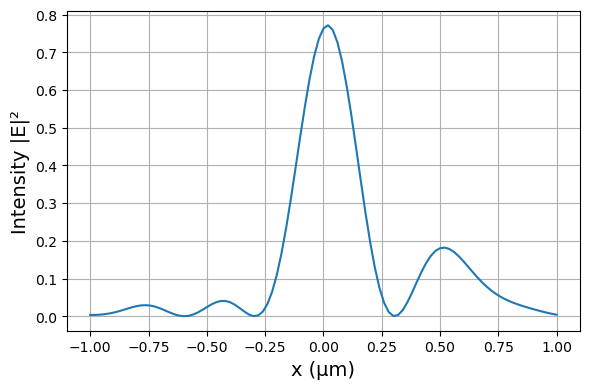


🔍 Source 5
  Input  flux : 0.246475
  Output flux : 0.284929
  EQE (%)     : 115.60 %

🔄 Iteration 시작 전 초기화: Source 6
▶️ Running Simulation for Source 6
📊 Plotting 2D Ez for Source 6


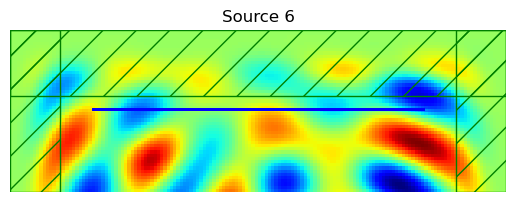

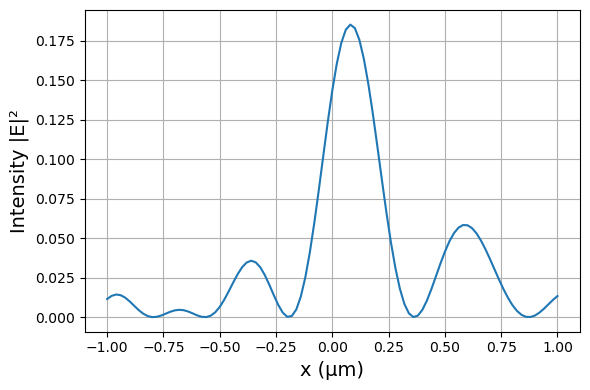


🔍 Source 6
  Input  flux : 0.094109
  Output flux : 0.086768
  EQE (%)     : 92.20 %

🔄 Iteration 시작 전 초기화: Source 7
▶️ Running Simulation for Source 7
📊 Plotting 2D Ez for Source 7


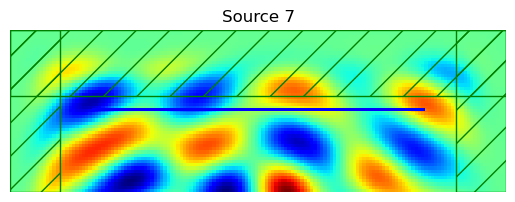

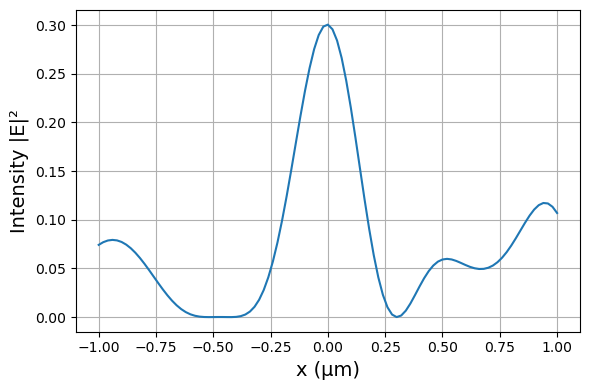


🔍 Source 7
  Input  flux : 0.157500
  Output flux : 0.249849
  EQE (%)     : 158.63 %

🔄 Iteration 시작 전 초기화: Source 8
▶️ Running Simulation for Source 8
📊 Plotting 2D Ez for Source 8


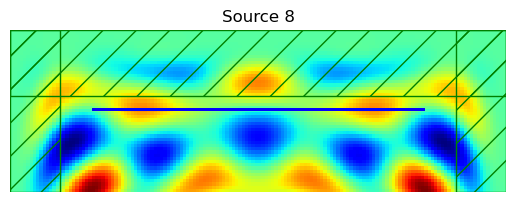

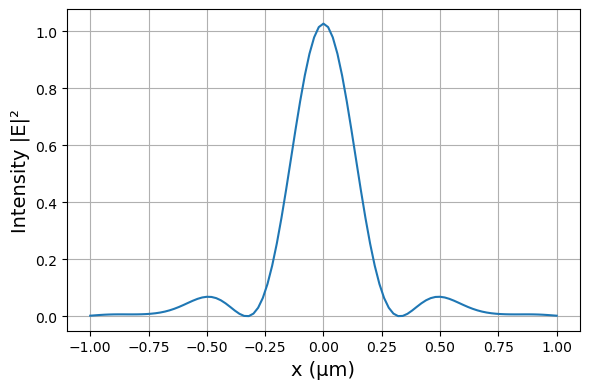


🔍 Source 8
  Input  flux : 0.289176
  Output flux : 0.331821
  EQE (%)     : 114.75 %

🔄 Iteration 시작 전 초기화: Source 9
▶️ Running Simulation for Source 9
📊 Plotting 2D Ez for Source 9


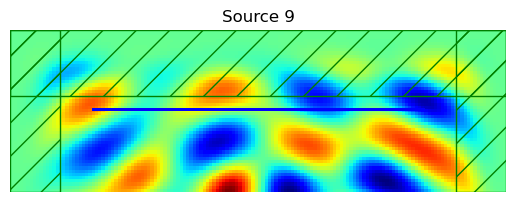

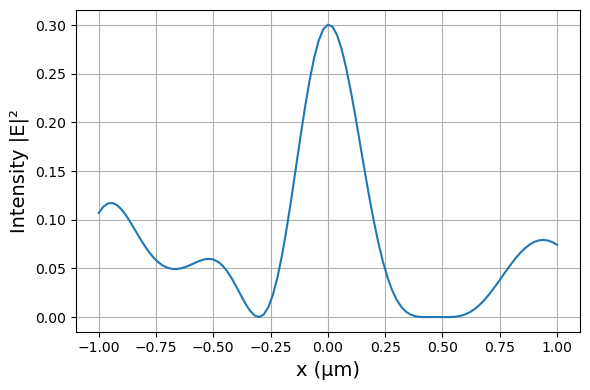


🔍 Source 9
  Input  flux : 0.157500
  Output flux : 0.249849
  EQE (%)     : 158.63 %

🔄 Iteration 시작 전 초기화: Source 10
▶️ Running Simulation for Source 10
📊 Plotting 2D Ez for Source 10


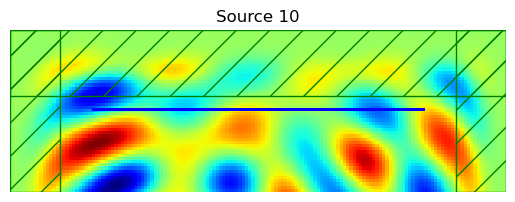

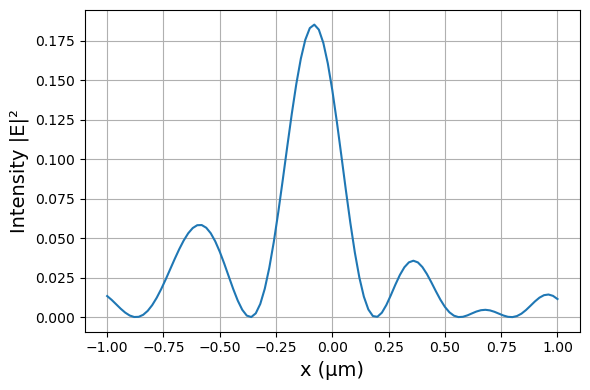


🔍 Source 10
  Input  flux : 0.094109
  Output flux : 0.086768
  EQE (%)     : 92.20 %

🔄 Iteration 시작 전 초기화: Source 11
▶️ Running Simulation for Source 11
📊 Plotting 2D Ez for Source 11


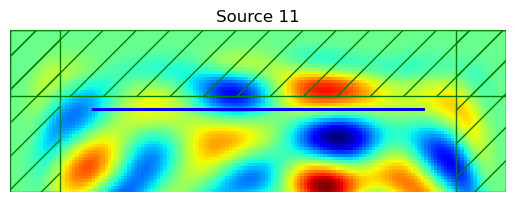

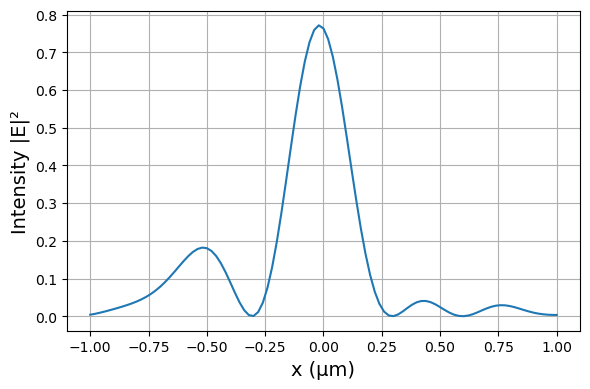


🔍 Source 11
  Input  flux : 0.246475
  Output flux : 0.284929
  EQE (%)     : 115.60 %

🔄 Iteration 시작 전 초기화: Source 12
▶️ Running Simulation for Source 12
📊 Plotting 2D Ez for Source 12


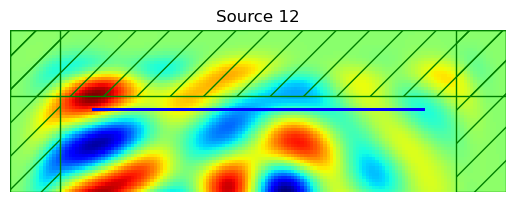

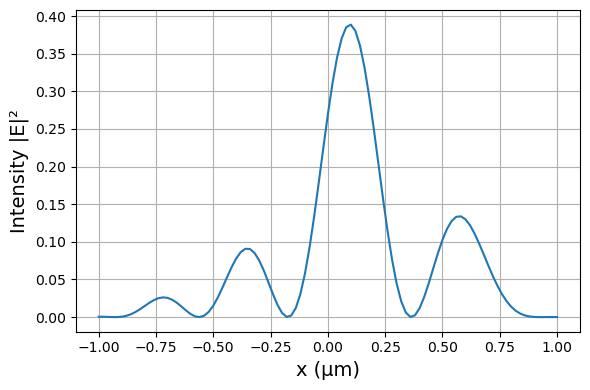


🔍 Source 12
  Input  flux : 0.198961
  Output flux : 0.168337
  EQE (%)     : 84.61 %

🔄 Iteration 시작 전 초기화: Source 13
▶️ Running Simulation for Source 13
📊 Plotting 2D Ez for Source 13


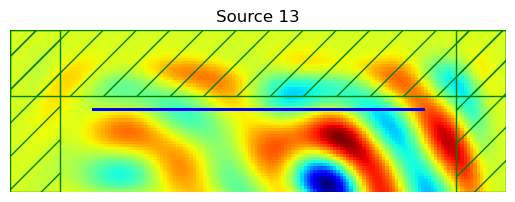

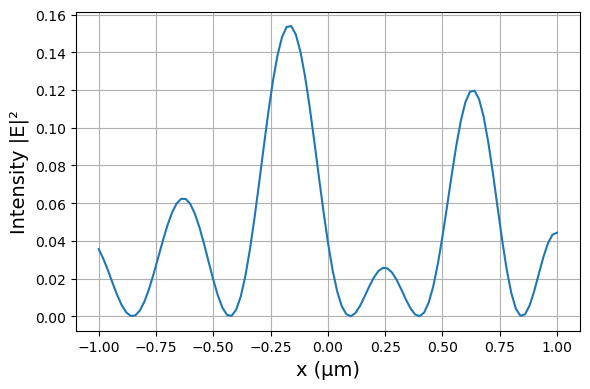


🔍 Source 13
  Input  flux : 0.132794
  Output flux : 0.125455
  EQE (%)     : 94.47 %

🔄 Iteration 시작 전 초기화: Source 14
▶️ Running Simulation for Source 14
📊 Plotting 2D Ez for Source 14


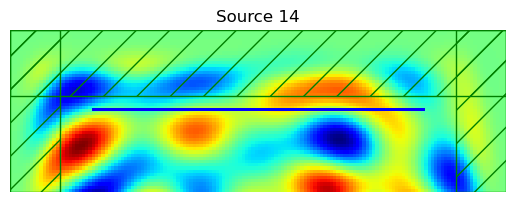

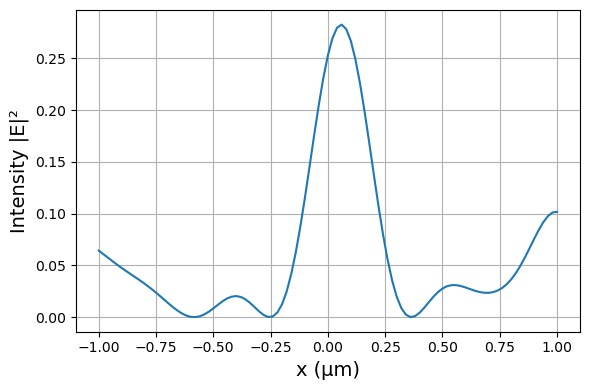


🔍 Source 14
  Input  flux : 0.146256
  Output flux : 0.129231
  EQE (%)     : 88.36 %

🔄 Iteration 시작 전 초기화: Source 15
▶️ Running Simulation for Source 15
📊 Plotting 2D Ez for Source 15


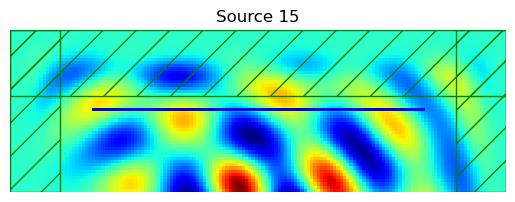

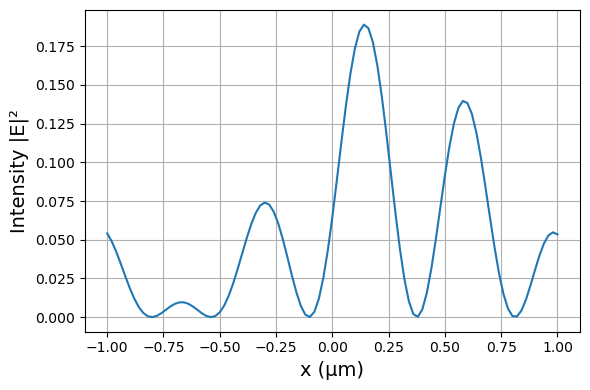


🔍 Source 15
  Input  flux : 0.173654
  Output flux : 0.136235
  EQE (%)     : 78.45 %

=== Summary EQE per source ===
Source 1: EQE = 78.45 %
Source 2: EQE = 88.36 %
Source 3: EQE = 94.47 %
Source 4: EQE = 84.61 %
Source 5: EQE = 115.60 %
Source 6: EQE = 92.20 %
Source 7: EQE = 158.63 %
Source 8: EQE = 114.75 %
Source 9: EQE = 158.63 %
Source 10: EQE = 92.20 %
Source 11: EQE = 115.60 %
Source 12: EQE = 84.61 %
Source 13: EQE = 94.47 %
Source 14: EQE = 88.36 %
Source 15: EQE = 78.45 %


In [75]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.01
flux_size = 0.02
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []

# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        # until_after_sources=mp.stop_when_fields_decayed(
        #     10/df, mp.Ez, src.center, 1e-5
        # )
        until = 300
    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.real(x),
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %")


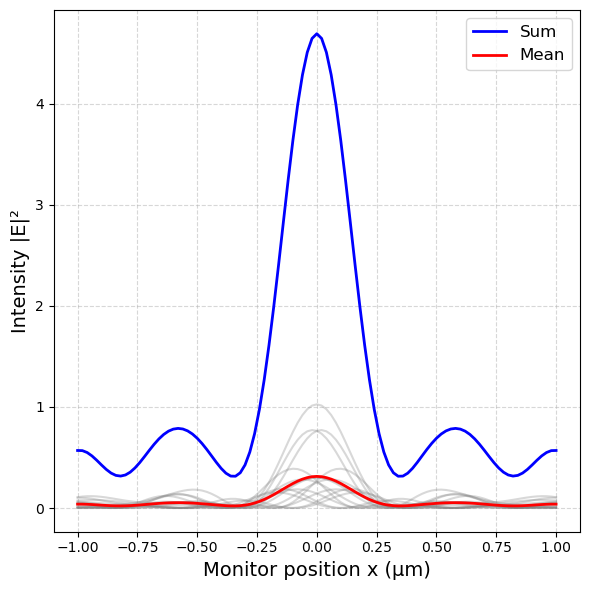

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# === 0) I_profiles 수집용 리스트 초기화 ===
I_profiles = []

# === 1) 각 sim에서 1D intensity 프로파일 계산 & 저장 ===
for sim, dft in zip(sims, dft_fields_list):
    # (이미 sim.run(...) 이 완료된 상태여야 합니다)
    E_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))  # 1D 배열 
    I = np.abs(E_line)**2                              # intensity
    I_profiles.append(I)

# === 2) x 좌표 벡터 생성 ===
N = I_profiles[0].size
x = np.linspace(-mn_size/2, mn_size/2, N)

# === 3) 합(sum) 및 평균(mean) 프로파일 계산 ===
I_stack = np.vstack(I_profiles)   # shape = (num_sources, N)
I_sum   = I_stack.sum(axis=0)     # 각 x 위치별 합
I_mean  = I_stack.mean(axis=0)    # 각 x 위치별 평균

# === 4) 한 그래프에 개별·합·평균 모두 그리기 ===
plt.figure(figsize=(6,6))

# (가) 개별 소스 프로파일: 연회색 얇은 선
for I in I_profiles:
    plt.plot(x, I, color='gray', alpha=0.3)

# (나) 합 프로파일: 검정 두꺼운 선
plt.plot(x, I_sum, 'b-', lw=2, label='Sum')

# (다) 평균 프로파일: 빨강 두꺼운 선
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')

plt.xlabel('Monitor position x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


적분 범위: ±0.340 µm → P_total(1차 링까지) = 0.106594


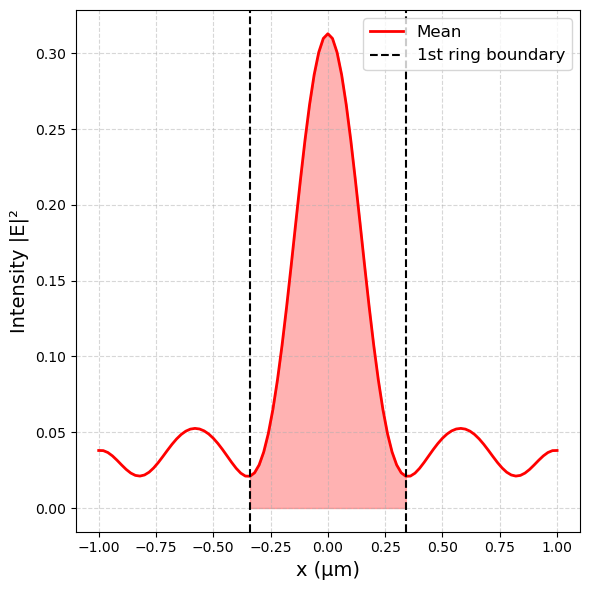

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean  = I_stack.mean(axis=0)   # sum 으로 되어 있던 부분 그대로

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

ring1_idx = minima_idx[0] if len(minima_idx)>0 else None
# ring2_idx = minima_idx[1] if len(minima_idx)>1 else None  # 더 이상 사용 안 함

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
# x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 적분 범위를 1차 링까지로 한정 ---
mask_total = (np.abs(x) <= x_ring1)   # <-- 2차 대신 1차 링까지
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# (원한다면 1차 링 내 세기도 별도 계산)
mask1 = mask_total
P1     = P_total
eff1   = 100.0  # P1 / P_total * 100 이므로 항상 100%

# --- 4) 결과 출력 ---
print(f"적분 범위: ±{x_ring1:.3f} µm → P_total(1차 링까지) = {P_total:.6f}")
# print(f"1차 링 내 세기 P1 = {P1:.6f}, 효율 = {eff1:.2f}%")

# --- 5) 시각화 ---
plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring1, ls='--', color='k', label='1st ring boundary')
plt.axvline(+x_ring1, ls='--', color='k')

plt.fill_between(x, I_mean, where=mask_total,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [84]:
0.106594/0.2839998666666667*100


37.53311621273061

적분 범위: ±0.340 µm → P_total(1차 링까지) = 0.107455


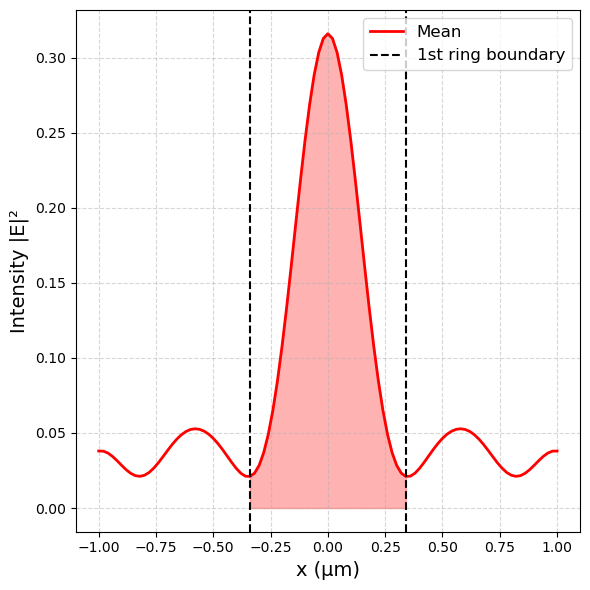

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean = I_stack.mean(axis=0)

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

ring1_idx = minima_idx[0] if len(minima_idx)>0 else None
# ring2_idx = minima_idx[1] if len(minima_idx)>1 else None  # 더 이상 사용 안 함

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
# x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 적분 범위를 1차 링까지로 한정 ---
mask_total = (np.abs(x) <= x_ring1)   # <-- 2차 대신 1차 링까지
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# (원한다면 1차 링 내 세기도 별도 계산)
mask1 = mask_total
P1     = P_total
eff1   = 100.0  # P1 / P_total * 100 이므로 항상 100%

# --- 4) 결과 출력 ---
print(f"적분 범위: ±{x_ring1:.3f} µm → P_total(1차 링까지) = {P_total:.6f}")
# print(f"1차 링 내 세기 P1 = {P1:.6f}, 효율 = {eff1:.2f}%")

# --- 5) 시각화 ---
plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring1, ls='--', color='k', label='1st ring boundary')
plt.axvline(+x_ring1, ls='--', color='k')

plt.fill_between(x, I_mean, where=mask_total,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


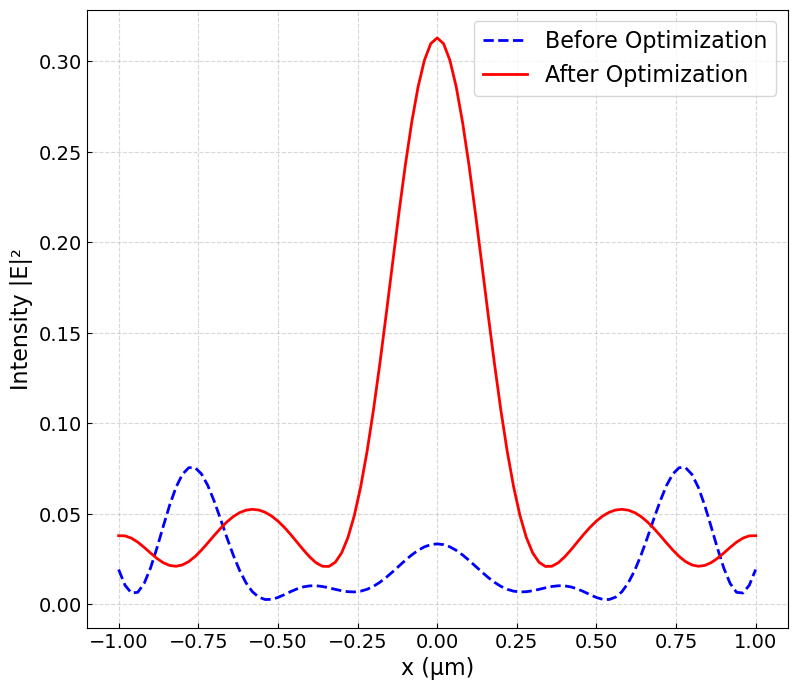

Average efficiency (Current/Saved mean): 552.50%


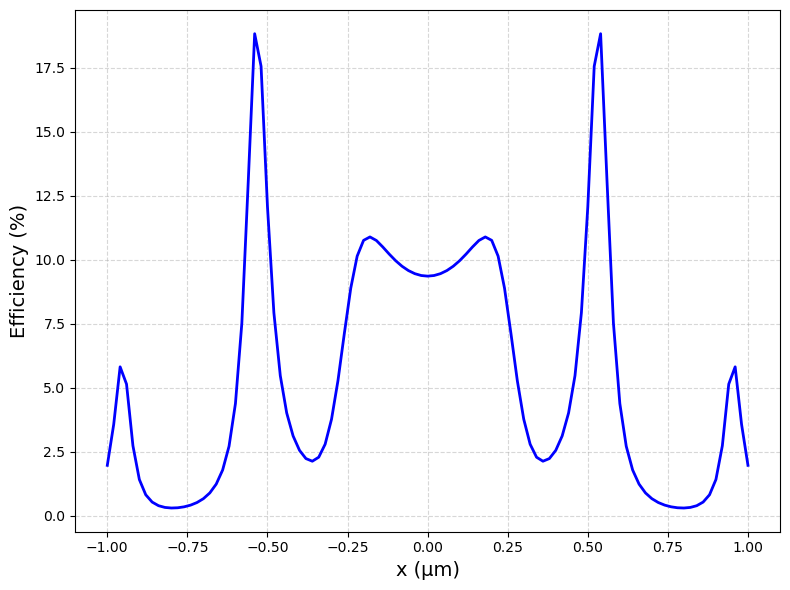

In [87]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '/home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt'

data = np.loadtxt(file_path)
x_loaded, I_sum_loaded, I_mean_loaded = data.T
plt.figure(figsize=(8,7))

plt.plot(x_loaded, I_mean_loaded, 'b--', lw=2, label='Before Optimization')

plt.plot(x, I_mean, 'r-', lw=2, label='After Optimization')

plt.xlabel('x (µm)', fontsize=16)
plt.ylabel('Intensity |E|²', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.show()

eff_line = (I_mean / I_mean_loaded) 

avg_eff = np.mean(eff_line)* 100
print(f"Average efficiency (Current/Saved mean): {avg_eff:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(x_loaded, eff_line, 'b-', lw=2)
plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Efficiency (%)', fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [74]:
0.107455/0.173126 

0.6206751152339914


Source 위치별 Input/Output flux
----------------------------------------
y = -0.800 µm  |  Input flux = 0.172750  |  Output flux = 0.136925
y = -0.686 µm  |  Input flux = 0.146533  |  Output flux = 0.129684
y = -0.571 µm  |  Input flux = 0.133216  |  Output flux = 0.125316
y = -0.457 µm  |  Input flux = 0.199303  |  Output flux = 0.169854
y = -0.343 µm  |  Input flux = 0.248018  |  Output flux = 0.286598
y = -0.229 µm  |  Input flux = 0.094696  |  Output flux = 0.087308
y = -0.114 µm  |  Input flux = 0.158432  |  Output flux = 0.250238
y = 0.000 µm  |  Input flux = 0.290994  |  Output flux = 0.334541
y = 0.114 µm  |  Input flux = 0.158432  |  Output flux = 0.250238
y = 0.229 µm  |  Input flux = 0.094696  |  Output flux = 0.087308
y = 0.343 µm  |  Input flux = 0.248018  |  Output flux = 0.286598
y = 0.457 µm  |  Input flux = 0.199303  |  Output flux = 0.169854
y = 0.571 µm  |  Input flux = 0.133216  |  Output flux = 0.125316
y = 0.686 µm  |  Input flux = 0.146533  |  Output flux = 0.12968

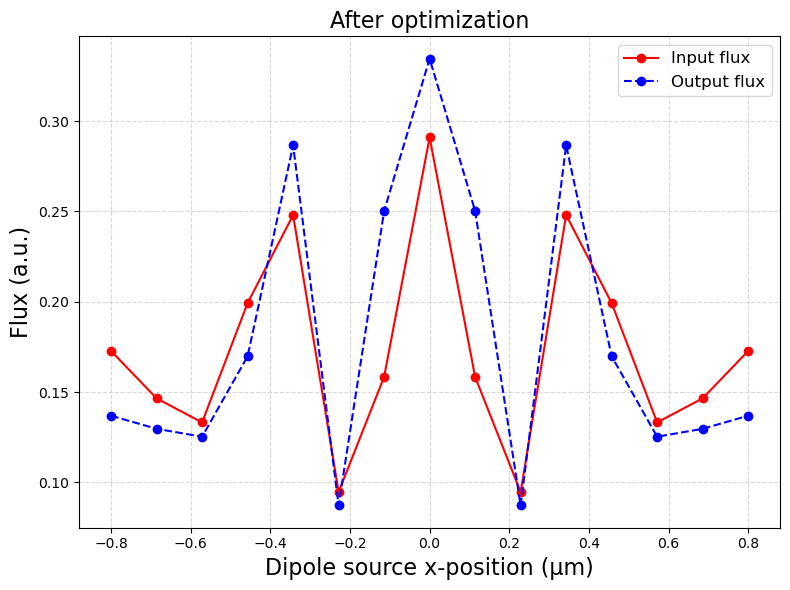


Source 위치별 Output/Input 비율 (%)
----------------------------------------
y = -0.800 µm  |  Output/Input = 79.26 %
y = -0.686 µm  |  Output/Input = 88.50 %
y = -0.571 µm  |  Output/Input = 94.07 %
y = -0.457 µm  |  Output/Input = 85.22 %
y = -0.343 µm  |  Output/Input = 115.56 %
y = -0.229 µm  |  Output/Input = 92.20 %
y = -0.114 µm  |  Output/Input = 157.95 %
y = 0.000 µm  |  Output/Input = 114.96 %
y = 0.114 µm  |  Output/Input = 157.95 %
y = 0.229 µm  |  Output/Input = 92.20 %
y = 0.343 µm  |  Output/Input = 115.56 %
y = 0.457 µm  |  Output/Input = 85.22 %
y = 0.571 µm  |  Output/Input = 94.07 %
y = 0.686 µm  |  Output/Input = 88.50 %
y = 0.800 µm  |  Output/Input = 79.26 %


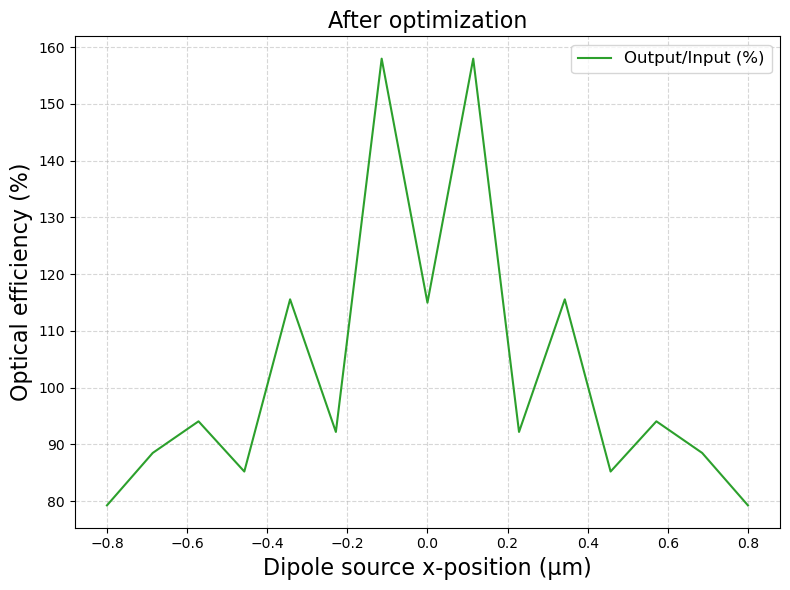

In [34]:
# === dipole 위치별 input/output flux 출력 & 플롯 ===

# 1) 소스의 y 위치 리스트
positions = [src.center.x for src in sources]

# 2) flux 값 추출
input_values  = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values = [mp.get_fluxes(f)[0] for f in output_flux_list]

# 3) 테이블 형태로 출력
print("\nSource 위치별 Input/Output flux")
print("-" * 40)
for y, inp, out in zip(positions, input_values, output_values):
    print(f"y = {y:.3f} µm  |  Input flux = {inp:.6f}  |  Output flux = {out:.6f}")

# 4) 한 그래프에 플롯
plt.figure(figsize=(8,6))
plt.plot(positions, input_values,  'ro-', label='Input flux')
plt.plot(positions, output_values, 'bo--', label='Output flux')
plt.xlabel('Dipole source x-position (µm)', fontsize=16)
plt.ylabel('Flux (a.u.)', fontsize=16)
plt.title('After optimization', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

print("\nSource 위치별 Output/Input 비율 (%)")
print("-" * 40)
for y, pct in zip(positions, percent_values):
    print(f"y = {y:.3f} µm  |  Output/Input = {pct:.2f} %")

plt.figure(figsize=(8,6))
plt.plot(positions, percent_values, '-', color='C2', label='Output/Input (%)')
plt.xlabel('Dipole source x-position (µm)', fontsize=16)
plt.ylabel('Optical efficiency (%)', fontsize=16)
plt.title('After optimization', fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


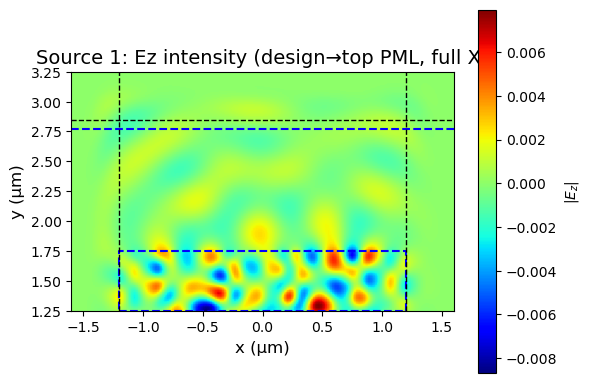

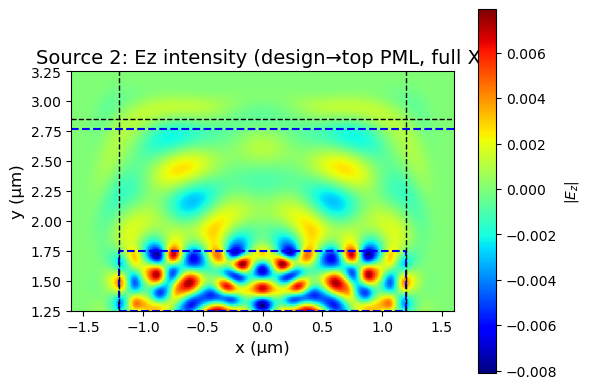

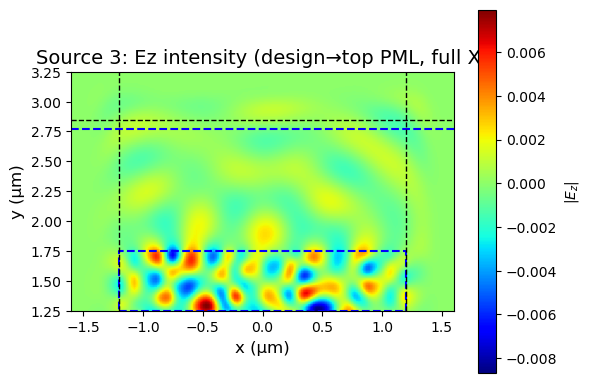

In [122]:
# 1) Y 범위: 디자인 영역 바닥→상단 PML 끝 (기존과 동일)
y_design_bot = center_y_design - design_region_height/2
y_start     = y_design_bot
y_end       = Sy/2

# 2) X 범위: 셀 전체 폭 (PML 포함)
x_start = -Sx/2
x_end   =  Sx/2

# 3) 해상도 벡터 재계산
nx   = int(resolution * Sx) + 1
x_res = np.linspace(x_start, x_end, nx)

ny   = int(resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

# 4) Volume 정의: X=Sx, Y=y_end–y_start
vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=mp.Vector3(Sx, y_end - y_start, 0)
)

# 5) 플롯 루프
# 5) 플롯 루프
for i in range(num_sources):
    Ez_slice = opt_list[i].sim.get_array(mp.Ez, vol).T
    I = np.real(Ez_slice)
    
    # I_max = np.max(np.real(Ez_slice))
    # I = np.real(Ez_slice)/I_max

    plt.figure(figsize=(6,4))
    plt.imshow(
        I,
        origin='lower',
        extent=[x_start, x_end, y_start, y_end],
        aspect='equal',
        cmap='jet'
    )
    plt.colorbar(label=r'$|E_z|$')
    plt.title(f"Source {i+1}: Ez intensity (design→top PML, full X)", fontsize=14)
    plt.xlabel('x (µm)', fontsize=12)
    plt.ylabel('y (µm)', fontsize=12)

    # — 디자인 영역 표시 —
    x0, x1 = -design_region_width/2, design_region_width/2
    y0 = y_design_bot
    y1 = y_design_bot + design_region_height
    plt.plot(
        [x0, x1, x1, x0, x0],
        [y0, y0, y1, y1, y0],
        'b--', lw=1.5, label='Design region'
    )

    # — 모니터 평면 표시 —
    plt.axhline(center_y_monitor_position, color='blue',
                ls='--', lw=1.5, label='Monitor plane')

    # — PML 경계 표시 (점선) —
    # 수평 PML 경계
    # plt.axhline(y_start + tpml,          color='yellow', ls='--', lw=1, label='Bottom PML end')
    plt.axhline(y_end   - tpml,          color='k', ls='--', lw=1, label='Top PML start')
    # 수직 PML 경계
    plt.axvline(x_start + tpml,          color='k', ls='--', lw=1, label='Left PML end')
    plt.axvline(x_end   - tpml,          color='k', ls='--', lw=1, label='Right PML start')

    # — 축범위 고정 —
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)

    # plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()



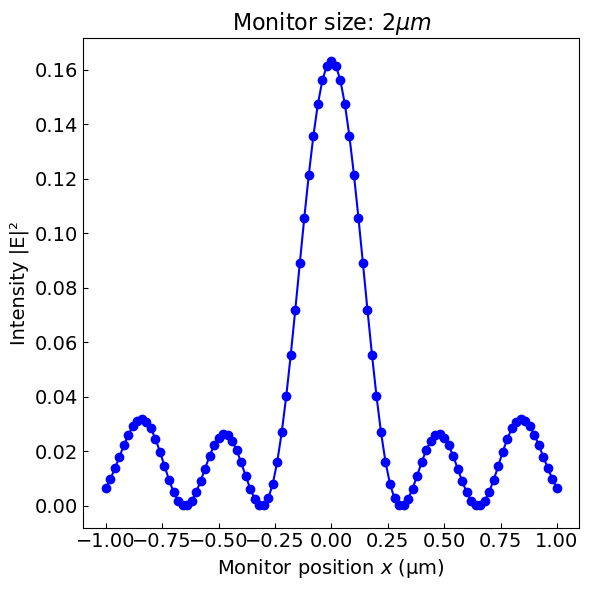

In [185]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

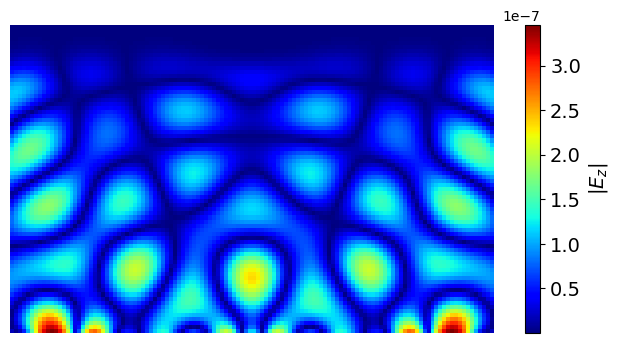

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt_list[2].sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

#### 소스 위치나 모니터 위치, 구조물 등등)

In [77]:
input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
print("Input되고 있는 flux : ", input)

NameError: name 'input_flux_list' is not defined

In [ ]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'

In [26]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.320 µm 구간 intensity 적분: 1.0391
모니터 기반 Optical EQE: 75.64%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'